## Topic Modeling

### Importing the necessary libraries

In [ ]:
pip install clean-text

In [1]:
import os, types
import numpy as np
import re
import csv
import json
import pandas as pd
from collections import Counter

In [66]:
import sklearn
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
from cleantext import clean
import numpy as np
import matplotlib.pyplot as plt

### Load the data

In [3]:
def jsonToDF(name):
    """Read a list of sentences from the JSON file, store them in a dataframe"""
    
    with open(f"{name}.json") as fin:
        textList = json.load(fin)

    # create a name for each document, based on its category
    indexNames = [f"{name}" for i in range(len(textList))]

    # create the dataframe, it will have one column and one index
    df = pd.DataFrame(data=textList, index=indexNames)
    df.columns = ['document']
    return df

In [4]:
user1 = jsonToDF("user1")
user2 = jsonToDF("user2")
user3 = jsonToDF("user3")
user4 = jsonToDF("user4")
user5 = jsonToDF("user5")
user6 = jsonToDF("user6")
user7 = jsonToDF("user7")
user8 = jsonToDF("user8")
user9 = jsonToDF("user9")
user10 = jsonToDF("user10")

In [5]:
user1 = user1.dropna(subset=['document'])
user2 = user2.dropna(subset=['document'])
user3 = user3.dropna(subset=['document'])
user4 = user4.dropna(subset=['document'])
user5 = user5.dropna(subset=['document'])
user6 = user6.dropna(subset=['document'])
user7 = user7.dropna(subset=['document'])
user8 = user8.dropna(subset=['document'])
user9 = user9.dropna(subset=['document'])
user10 = user10.dropna(subset=['document'])

Concatenate all of them in a single dataframe:

In [6]:
allDocs = pd.concat([user1, user2, user3, user4, user5, user6, user7, user8, user9, user10])
allDocs.shape

(88413, 1)

In [7]:
#drop duplicates
allDocs.drop_duplicates(inplace=True)
allDocs.shape

(81465, 1)

In [8]:
pd.set_option("display.max_colwidth",1000)
#allDocs.head()

In [9]:
def getHashtags(text):
  """Takes a string phrase and returns hashtags if present"""
  if isinstance(text, str):
    return re.findall(r"#(\S+)", text.lower())
  return []

In [10]:
#extracts the hashtags for each post
allDocs['hashtags'] = allDocs['document'].apply(getHashtags)
allDocs.head()

,document,hashtags
user1,"A couple bags of balloons, some left over decorations from my other daughters birthday, a few borrowed items from friends and family, and an hour or so of work, and they had a night to remember!! But the real question is, do you remember your first sleepover?!? 🤍🎈 #birthday #sleepover #party","[birthday, sleepover, party]"
user1,who would you bring on a trip to the Bahamas 🌺 #honeymoon #travelbucketlist #thebahamas #caribbean #vacationinspo,"[honeymoon, travelbucketlist, thebahamas, caribbean, vacationinspo]"
user1,Things to do in Cabo - Part 2! 🇲🇽 #cabo #cabosanlucas #traveltok #travelblogger,"[cabo, cabosanlucas, traveltok, travelblogger]"
user1,All the details to our 4 day trip in Cabo. ✨ #fyp #whatwespent #cabo #cabosanlucas #travel,"[fyp, whatwespent, cabo, cabosanlucas, travel]"
user1,Let’s detox my son’s locs with me after 3 months #fypシ,[fypシ]


In [11]:
def splitHashtags(sentence):
    """Takes a sentence and splits hashtags if present"""
    if isinstance(sentence, str):
        hashtags = [tag.strip('#') for tag in sentence.split('#') if tag.strip('#')]
        return hashtags
    return []

In [12]:
RE_EMOJI = re.compile('[\U00010000-\U0010ffff]', flags=re.UNICODE)

def strip_emoji(text):
    return RE_EMOJI.sub(r'', text)

In [13]:
toRemove = ['fyp', '#trending', 'trending', '#foryou', 'foryou', '#viral', 'viral', 'foryoupage', 'fy', 'fypage', 'tiktok', 'video', 'forypu', 'fup', 'everyonefyp', 'reaction', 'fypviral']

def remove_words(sentence):
    #if isinstance(sentence, str):
        sent = strip_emoji(sentence)
        hashtags = splitHashtags(sent)
        final = []
        for hash in hashtags:
            #print(type(hash))
            if hash.lower() not in toRemove and hash not in final:
                final.append(hash)
        return ' '.join(final)

allDocs['document'] = allDocs['document'].apply(remove_words)
pd.set_option("display.max_colwidth",1000)
allDocs.head()

,document,hashtags
user1,"A couple bags of balloons, some left over decorations from my other daughters birthday, a few borrowed items from friends and family, and an hour or so of work, and they had a night to remember!! But the real question is, do you remember your first sleepover?!? birthday sleepover party","[birthday, sleepover, party]"
user1,who would you bring on a trip to the Bahamas honeymoon travelbucketlist thebahamas caribbean vacationinspo,"[honeymoon, travelbucketlist, thebahamas, caribbean, vacationinspo]"
user1,Things to do in Cabo - Part 2! cabo cabosanlucas traveltok travelblogger,"[cabo, cabosanlucas, traveltok, travelblogger]"
user1,All the details to our 4 day trip in Cabo. ✨ fyp whatwespent cabo cabosanlucas travel,"[fyp, whatwespent, cabo, cabosanlucas, travel]"
user1,Let’s detox my son’s locs with me after 3 months fypシ,[fypシ]


Jaccard index on suggested words and video descriptons between users

### Convert to document-term matrix

In [14]:
from sklearn.feature_extraction.text import CountVectorizer

In [20]:
# Initialize the vectorizer
vectorizer = CountVectorizer(
    strip_accents='unicode',
    stop_words='english',
    lowercase=True,
    token_pattern=r'\b[a-zA-Z]{3,}\b', # we want only words that contain letters and are 3 or more characters long
)

# Transform our data into the document-term matrix
dtm = vectorizer.fit_transform(allDocs['document'])
dtm

<81465x110847 sparse matrix of type '<class 'numpy.int64'>'
	with 848325 stored elements in Compressed Sparse Row format>

In [21]:
feature_names = vectorizer.get_feature_names_out()
feature_names

array(['aaa', 'aaaa', 'aaaaaaaaaaa', ..., 'zyzz', 'zzuzzhas',
       'zzzachariah'], dtype=object)

In [22]:
def matrix2Doc(dtMatrix, features, index):
    """Turns each row of the document-term matrix into a list of terms"""
    row = dtMatrix.getrow(index).toarray()
    non_zero_indices = row.nonzero()[1]
    words = [features[idx] for idx in non_zero_indices]
    return words

In [23]:
allDocsAsTerms = [matrix2Doc(dtm, feature_names, i) for i in range(dtm.shape[0])]

In [24]:
allDocs['terms'] = allDocsAsTerms
pd.set_option("display.max_colwidth",1000)
allDocs.head()

,document,hashtags,terms
user1,"A couple bags of balloons, some left over decorations from my other daughters birthday, a few borrowed items from friends and family, and an hour or so of work, and they had a night to remember!! But the real question is, do you remember your first sleepover?!? birthday sleepover party","[birthday, sleepover, party]","[bags, balloons, birthday, borrowed, couple, daughters, decorations, family, friends, hour, items, left, night, party, question, real, remember, sleepover, work]"
user1,who would you bring on a trip to the Bahamas honeymoon travelbucketlist thebahamas caribbean vacationinspo,"[honeymoon, travelbucketlist, thebahamas, caribbean, vacationinspo]","[bahamas, bring, caribbean, honeymoon, thebahamas, travelbucketlist, trip, vacationinspo]"
user1,Things to do in Cabo - Part 2! cabo cabosanlucas traveltok travelblogger,"[cabo, cabosanlucas, traveltok, travelblogger]","[cabo, cabosanlucas, things, travelblogger, traveltok]"
user1,All the details to our 4 day trip in Cabo. ✨ fyp whatwespent cabo cabosanlucas travel,"[fyp, whatwespent, cabo, cabosanlucas, travel]","[cabo, cabosanlucas, day, details, fyp, travel, trip, whatwespent]"
user1,Let’s detox my son’s locs with me after 3 months fypシ,[fypシ],"[detox, let, locs, months, son]"


### Fitting the LDA model

In [25]:
from sklearn.decomposition import LatentDirichletAllocation

In [ ]:
#from sklearn.model_selection import GridSearchCV

# We are going to test multiple values for the number of topics
search_params = {'n_components': [5, 10, 15, 20, 25, 30, 35]}

# Initialize the LDA model
#lda = LatentDirichletAllocation()

# Initialize a Grid Search with cross-validation instance
#grid = GridSearchCV(lda, param_grid=search_params)

# Do the Grid Search
#grid.fit(dtm)

In [ ]:
grid.cv_results_

In [ ]:
# Best Model
#best_lda_model = grid.best_estimator_

# Model Parameters
#print("Best Model's Params: ", grid.best_params_)

# Log Likelihood Score
#print("Best Log Likelihood Score: ", grid.best_score_)

# Perplexity
#print("Model Perplexity: ", best_lda_model.perplexity(dtm))

In [57]:
# Step 1: Initialize the model
lda = LatentDirichletAllocation(n_components=5, # we are picking the number of topics arbitrarely at the moment
                                random_state=0)
# Step 2: Fit the model
lda.fit(dtm)

LatentDirichletAllocation(n_components=5, random_state=0)

In [58]:
lda.components_.shape

(5, 110847)

In [59]:
doc_topic_dist = lda.transform(dtm)
doc_topic_dist 

array([[0.08386735, 0.36577309, 0.39135399, 0.1502246 , 0.00878098],
       [0.02393292, 0.53302452, 0.02273061, 0.02235851, 0.39795343],
       [0.02861373, 0.02898257, 0.19169061, 0.02892101, 0.72179207],
       ...,
       [0.29501701, 0.00957909, 0.00963278, 0.67619825, 0.00957288],
       [0.9700224 , 0.00753269, 0.00746493, 0.00750586, 0.00747413],
       [0.01036179, 0.26856348, 0.01022994, 0.01036016, 0.70048462]])

In [60]:
doc_topic_dist.shape

(81465, 5)

In [61]:
def display_topics(model, features, no_top_words):
    """Helper function to show the top words of a model"""
    for topic_idx, topic in enumerate(model.components_):                                                                                                             
        print(f"Topic {topic_idx}:")
        print(" ".join([features[i]
                        for i in topic.argsort()[:-no_top_words-1:-1]])) # syntax for reversing a list [::-1]

display_topics(lda, feature_names, 30)

Topic 0:
fyp foryou funny viral tiktok makeup foryoupage wedding movie jackson replying teacher avatar nicki trending video percy girl song games love minaj like relatable just videos sister car book edit
Topic 1:
christmas fyp stitch family life like day outfits mom outfit tiktok home thrift just time fashion school haul house people bachelor dad love think good parents old work replying got
Topic 2:
hair baby filter new nyc boston fyp doctor tiktok york like golden birthday david edit girl face doctorwho year good smith song videos davidtennant color know day tennant josh fortnite
Topic 3:
love dog tiktok lip makeup bag water costume movie halloween cheese girls skin recipe blind mean make couple dune food cream ideas skincare videos girl cup cleaning dress dogs ariana
Topic 4:
taylor college swift cat food tiktok fyp tour taylorswift cats disney life videos university student song olivia funny soup travis rodrigo chicken harry travel african like new songs eras williams


In [75]:
def displayHeader(model, features, no_top_words):
    """Helper function to show the top words of a model"""
    topicNames = []
    for topic_idx, topic in enumerate(model.components_):
        topicNames.append(f"Topic {topic_idx}: " + (", ".join([features[i]
                             for i in topic.argsort()[:-no_top_words-1:-1]])))
    return topicNames

In [76]:
# column names
topicnames = displayHeader(lda, feature_names, 0)

# index names
docnames = allDocs.index.tolist() # We will use the original names of the documents

# Make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(doc_topic_dist, 3), 
                                 columns=topicnames, 
                                 index=docnames)

# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1) # finds the maximum argument
df_document_topic['dominant_topic'] = dominant_topic

df_document_topic.tail()

,Topic 0:,Topic 1:,Topic 2:,Topic 3:,Topic 4:,dominant_topic
user10,0.007,0.972,0.007,0.007,0.007,1
user10,0.009,0.875,0.097,0.009,0.009,1
user10,0.295,0.010,0.010,0.676,0.010,3
user10,0.970,0.008,0.007,0.008,0.007,0
user10,0.010,0.269,0.010,0.010,0.700,4


In [85]:
#df_document_topic = df_document_topic.reset_index()
#df_document_topic = df_document_topic.drop(columns = ['dominant_topic'])
df_document_topic.head()

,index,Topic 0:,Topic 1:,Topic 2:,Topic 3:,Topic 4:
0,user1,0.084,0.366,0.391,0.150,0.009
1,user1,0.024,0.533,0.023,0.022,0.398
2,user1,0.029,0.029,0.192,0.029,0.722
3,user1,0.020,0.020,0.448,0.020,0.491
4,user1,0.034,0.035,0.864,0.034,0.034


In [89]:
grouped = df_document_topic.groupby('index')

In [91]:
averages = grouped.mean()
averages

,Topic 0:,Topic 1:,Topic 2:,Topic 3:,Topic 4:
index,,,,,
user1,0.201286,0.206714,0.138014,0.256114,0.197686
user10,0.217650,0.240963,0.134767,0.198615,0.207941
user2,0.274779,0.206505,0.188316,0.148760,0.181615
user3,0.238766,0.218477,0.195710,0.144630,0.202409
user4,0.235899,0.237811,0.144037,0.180670,0.201583
user5,0.237324,0.226752,0.158770,0.199286,0.177862
user6,0.402353,0.191676,0.042882,0.167529,0.195529
user7,0.178806,0.252155,0.159727,0.238555,0.170749
user8,0.228112,0.236044,0.149988,0.173541,0.212309


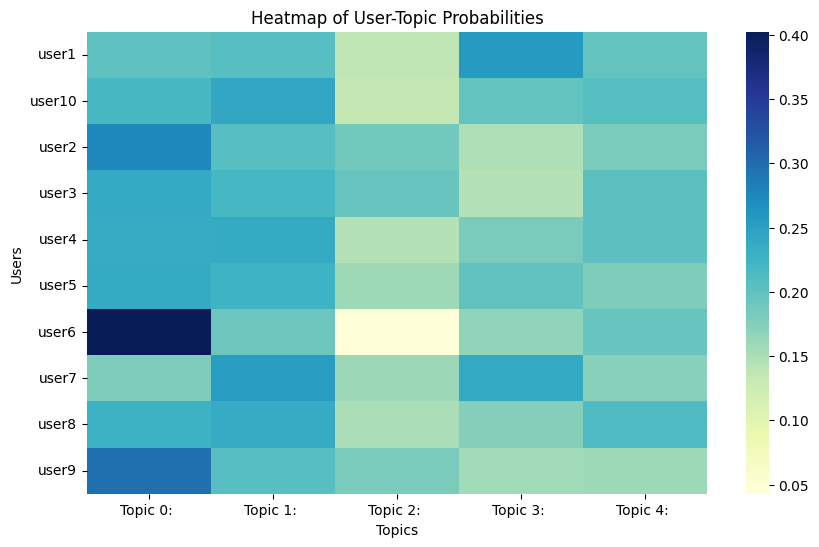

In [94]:
# Plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(averages, cmap="YlGnBu", fmt="d")
plt.title('Heatmap of User-Topic Probabilities')
plt.xlabel('Topics')
plt.ylabel('Users')
plt.yticks(rotation=0)
plt.show()

In [64]:
df_topic_distribution = df_document_topic['dominant_topic'].value_counts().reset_index(name="Num Documents")
df_topic_distribution.columns = ['Topic Num', 'Num Video Descriptions']
df_topic_distribution

,Topic Num,Num Video Descriptions
0,0,19858
1,1,19563
2,4,14585
3,3,14160
4,2,13299


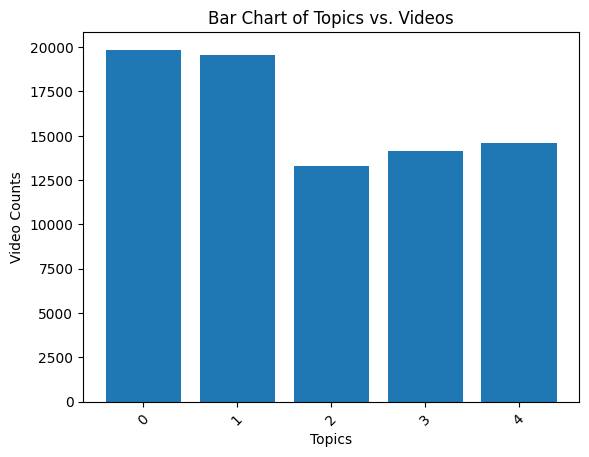

In [69]:
# Extract data from DataFrame columns
x_values = df_topic_distribution['Topic Num']
y_values = df_topic_distribution['Num Video Descriptions']

# Plot the bar chart
plt.bar(x_values, y_values)

# Add labels and title
plt.xlabel('Topics')
plt.ylabel('Video Counts')
plt.title('Bar Chart of Topics vs. Videos')

# Rotate x-axis labels for better readability (if needed)
plt.xticks(rotation=45)

# Show the plot
plt.show()

In [ ]:
# Assuming 'df' is your DataFrame
df_document_topic.reset_index(inplace=True)
df_document_topic.head(25)

In [ ]:
# Extract data from DataFrame columns
x_values = df_document_topic['index']
y_values = df_document_topic['dominant_topic']

# Plot the bar chart
plt.bar(x_values, y_values)

# Add labels and title
plt.xlabel('Topics')
plt.ylabel('Video Counts')
plt.title('Bar Chart of Topics vs. Videos')

# Rotate x-axis labels for better readability (if needed)
plt.xticks(rotation=45)

# Show the plot
plt.show()

In [ ]:
# Find the most frequent dominant_topic per user
most_frequent_topics = df_document_topic.groupby('index')['dominant_topic'].apply(lambda x: x.mode().iloc[0])

# Print the result
type(most_frequent_topics)

In [ ]:
# Find the most frequent dominant_topic per user
most_frequent_topics = df_document_topic.groupby('index')['dominant_topic'].apply(lambda x: x.value_counts().idxmax())

# Print the result
most_frequent_topics

In [ ]:
# Plot the bar chart
plt.figure(figsize=(10, 6))
most_frequent_topics.value_counts().plot(kind='bar')
plt.title('Most Frequent Dominant Topic per User')
plt.xlabel('Dominant Topic')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.grid(axis='y')

# Show the plot
plt.show()